# Aplicando PCA sobre RandomForest

En este JN, voy a aplicarle un PCA para saber si puedo mejorar mi modelo de alguna forma.

Al final, en la sección de Conclusiones, valoraré si finalmente le aplico a mi modelo PCA o no.

*Cada vez que aplico un PCA vuelvo a importar las librerías y a cargar el datasaset dado que si no lo hago me da error al calcular determinados scores o coeficientes.

Empiezo importando las librerías que voy a utilizar y cargando mi dataset.

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

In [8]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')

# PCA - 5

Empiezo probando a reducir el número de features de mi modelo a 5, para obtener las diferentes métricas que he obtenido antes, y ver si mejoran sustancialmente mis resultados.

Empiezo escalando las diferentes features que tengo para podemos aplicarle el PCA.

In [12]:
features = ['mfcc', 'scem', 'scom', 'srom', 'sbwm', 'tempo', 'rmse']

x = data.loc[:, features].values
y = data.loc[:,['momento_aux']].values

x = StandardScaler().fit_transform(x)

A continuación le aplico el PCA, reduciendo las features de 7 a 5, y muestro el dataset resultante.

In [13]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-2.908475,-1.183207,0.004665,-0.692620,-0.159871
1,0.597411,-1.375698,0.282320,-0.717515,0.182912
2,0.580970,3.266432,-0.161297,0.105091,0.430711
3,-0.744115,-1.413075,0.030856,-0.458438,-0.523544
4,-2.020234,-1.225178,-0.258659,0.596813,-0.563518


Y ahora, para poder trabajar y concatenar la X y la y de forma correcta y que no me de errores, reseteo los índices de ambos dataframes.

In [15]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento_aux']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,momento_aux
0,-2.908475,-1.183207,0.004665,-0.692620,-0.159871,Lavadora
1,0.597411,-1.375698,0.282320,-0.717515,0.182912,Aspiradora
2,0.580970,3.266432,-0.161297,0.105091,0.430711,Ducha
3,-0.744115,-1.413075,0.030856,-0.458438,-0.523544,Lavadora
4,-2.020234,-1.225178,-0.258659,0.596813,-0.563518,Lavadora


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_xlabel('Principal Component 4', fontsize = 15)
ax.set_xlabel('Principal Component 5', fontsize = 15)

ax.set_title('5 component PCA', fontsize = 20)
targets = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
           'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
           'Licuadora', 'Alarma', 'Grifo', 'Microondas']
colors = ['r', 'g', 'b', 'y', 'k', 'gray', 'bisque', 'navy', 'olive', 'plum', 'teal', 'pink', 'wheat', 
          'maroon', 'skyblue', 'crimson']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['momento_aux'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], 
               finalDf.loc[indicesToKeep, 'principal component 2'], 
               finalDf.loc[indicesToKeep, 'principal component 3'], 
               finalDf.loc[indicesToKeep, 'principal component 4'], 
               finalDf.loc[indicesToKeep, 'principal component 5'], 
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()

Debido a la reducción de features al aplicar el CA, parte de la totalidad de la variación explicada del modelo original se pierde, por lo que voy a ver cómo se distribuye esta variación entre las 5 features, cuánta variación se explica y cuánta se ha perdido.

In [22]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.48546933 0.20640729 0.13593341 0.09685188 0.04908501] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 97.37%.
La variación perdida con respecto al modelo original ha sido del 2.63%.


Como se puede observar debajo, la correlación entre las diferentes features prácticamente ha desaparecido.

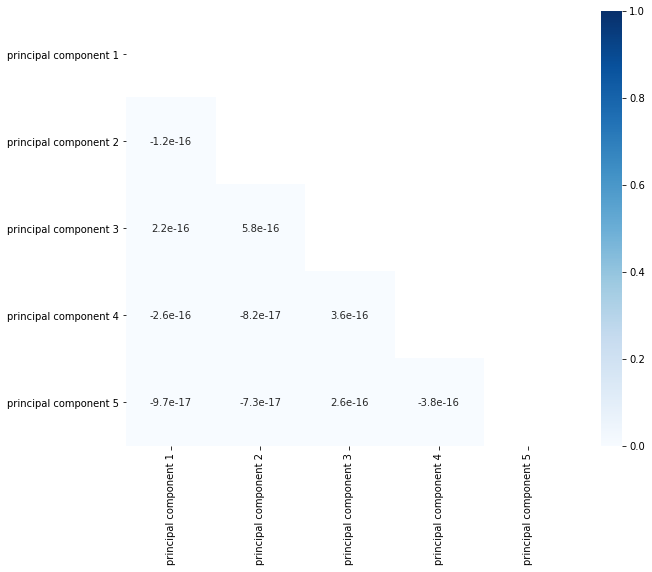

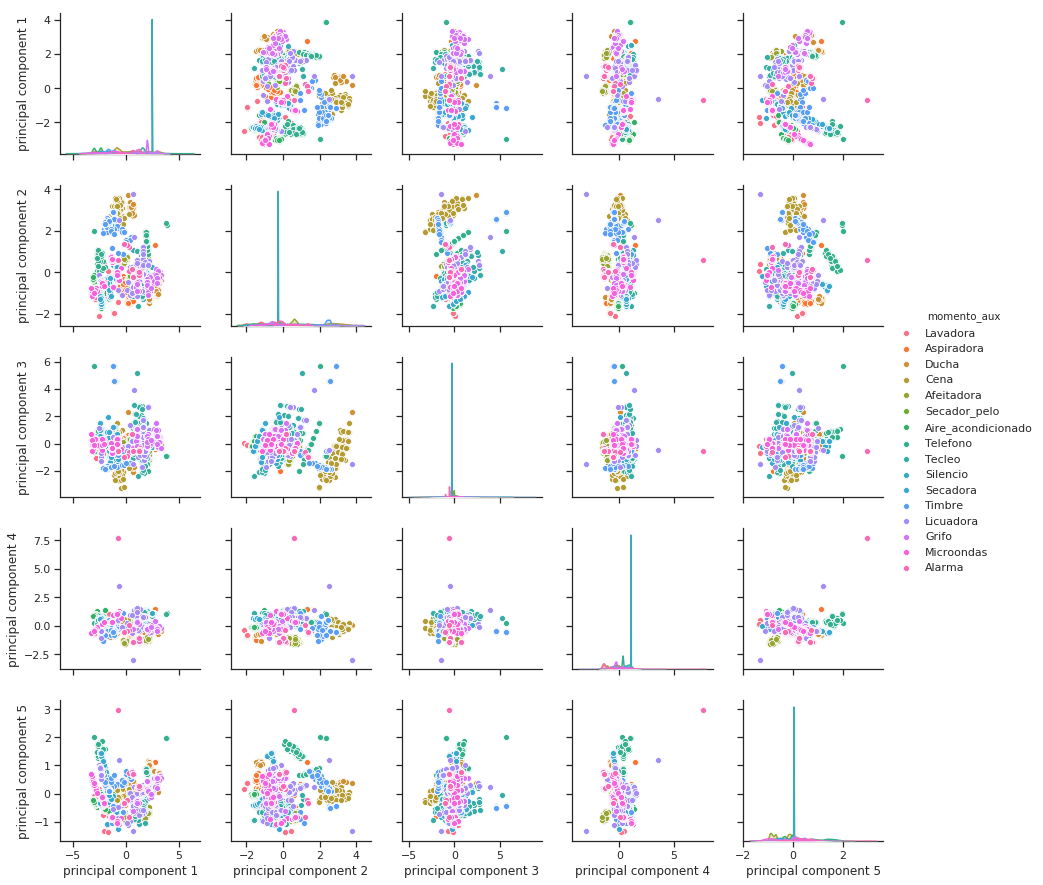

In [23]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

    sns.set(style="ticks")
    sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento_aux')

Y termino con el mismo análisis que hice con el modelo original.

Es por ello que noy voy a entrar a dar epxlicaciones ni para este modelo ni para el resto de PCA, dado que las voy a dar todas juntas en la sección final de Conclusiones de este JN.

In [24]:
y = pd.get_dummies(data=finalDf.momento_aux)
X = data.loc[:, finalDf.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [25]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.98657718 0.90540541 0.93918919 0.97297297 1.         0.91891892
 0.98648649 0.18918919 0.95945946 0.94594595 0.99324324 0.94594595
 0.97297297 0.93243243 0.85810811 0.93243243 0.96621622 1.
 0.9527027  0.9527027 ]
Accuracy: 0.92 (+/- 0.34)


In [26]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9612141652613828

In [27]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.01
Cena                  0.00
Ducha                 0.00
Grifo                 0.01
Lavadora              0.00
Licuadora             0.01
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


In [28]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [29]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [30]:
indices = np.argsort(importances)[::-1]

In [31]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.251771)
2. feature 4 (0.222185)
3. feature 0 (0.193594)
4. feature 1 (0.186591)
5. feature 3 (0.145859)


,importance
scom,0.251771
sbwm,0.222185
mfcc,0.193594
scem,0.186591
srom,0.145859


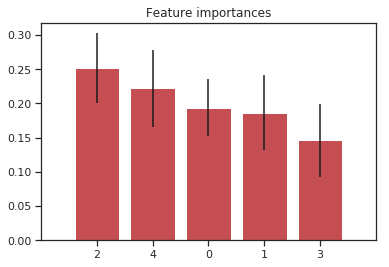

In [32]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [33]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9612141652613828

In [34]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9628238878257158

In [35]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.607143,1.000000,0.755556
Ducha,1.000000,0.975000,0.987342
Lavadora,1.000000,0.954545,0.976744
Aspiradora,0.966667,0.878788,0.920635
Afeitadora,1.000000,0.962963,0.981132
Secador_pelo,1.000000,0.966667,0.983051
Aire_acondicionado,1.000000,0.936170,0.967033
Telefono,1.000000,0.979167,0.989474
Tecleo,1.000000,0.891304,0.942529


Confusion matrix, without normalization
[[34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 47  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0 39  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 39  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0]
 [ 1  0  0  1  0  0  0  0  0  0  0  0  0  0  0 32]]


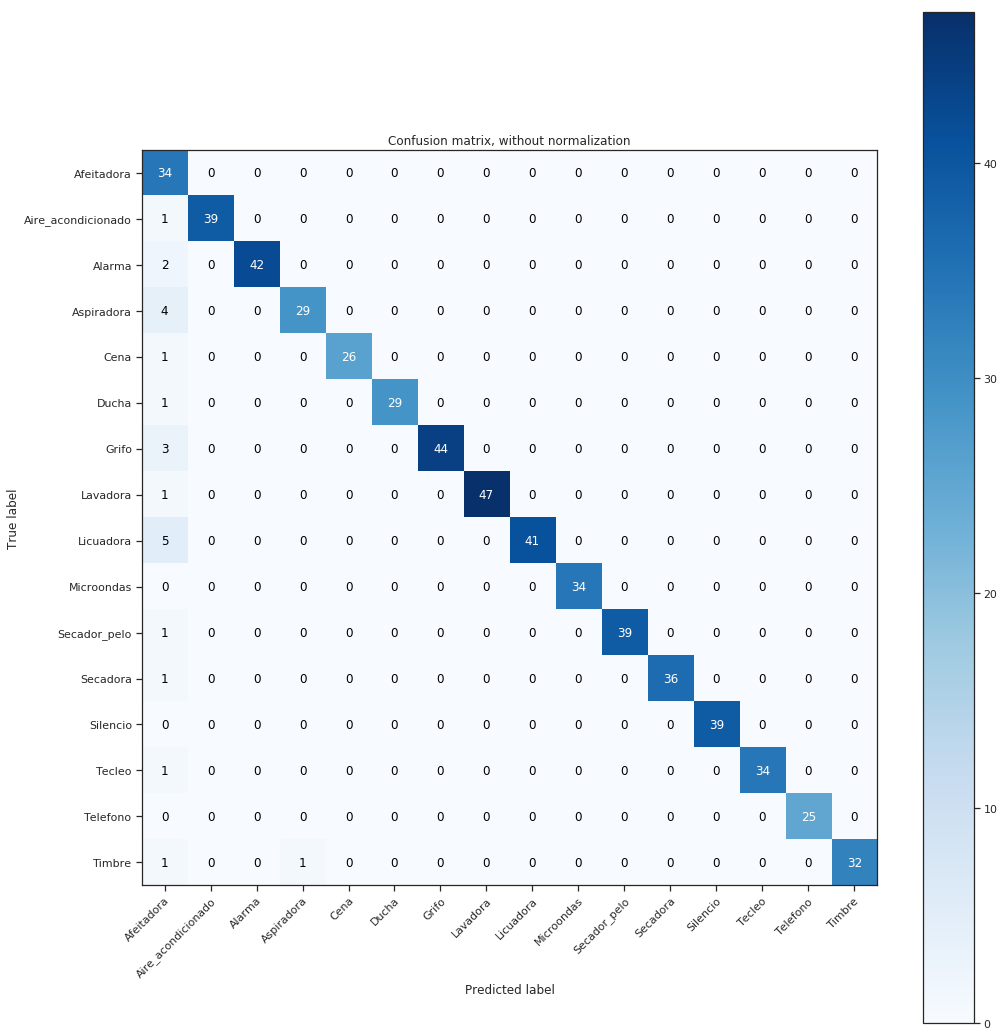

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [37]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [39]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [41]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [42]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [43]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [44]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

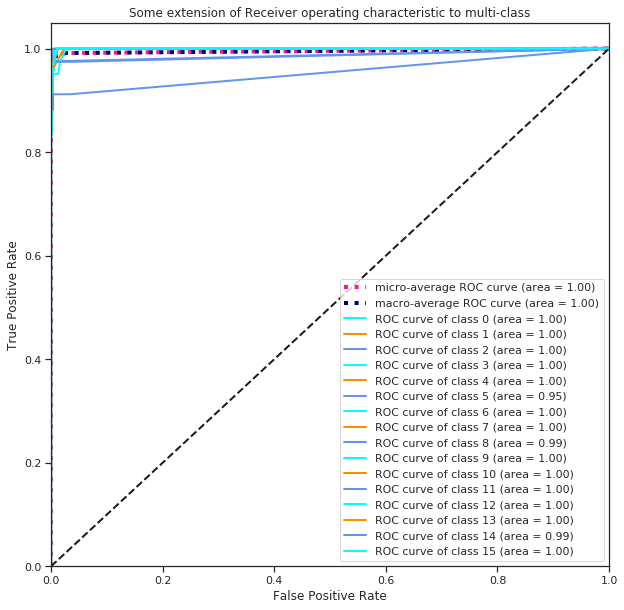

In [45]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 6

In [46]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [47]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')

In [48]:
features = ['mfcc', 'scem', 'scom', 'srom', 'sbwm', 'tempo', 'rmse']

x = data.loc[:, features].values
y = data.loc[:,['momento_aux']].values

x = StandardScaler().fit_transform(x)

In [50]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,-2.908475,-1.183207,0.004665,-0.692620,-0.159871,-0.175574
1,0.597411,-1.375698,0.282320,-0.717515,0.182912,-0.073189
2,0.580970,3.266432,-0.161297,0.105091,0.430711,0.112332
3,-0.744115,-1.413075,0.030856,-0.458438,-0.523544,-0.448938
4,-2.020234,-1.225178,-0.258659,0.596813,-0.563518,0.295276


In [51]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento_aux']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,momento_aux
0,-2.908475,-1.183207,0.004665,-0.692620,-0.159871,-0.175574,Lavadora
1,0.597411,-1.375698,0.282320,-0.717515,0.182912,-0.073189,Aspiradora
2,0.580970,3.266432,-0.161297,0.105091,0.430711,0.112332,Ducha
3,-0.744115,-1.413075,0.030856,-0.458438,-0.523544,-0.448938,Lavadora
4,-2.020234,-1.225178,-0.258659,0.596813,-0.563518,0.295276,Lavadora


In [52]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.48546933 0.20640729 0.13593341 0.09685188 0.04908501 0.02396866] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 99.77%.
La variación perdida con respecto al modelo original ha sido del 0.23%.


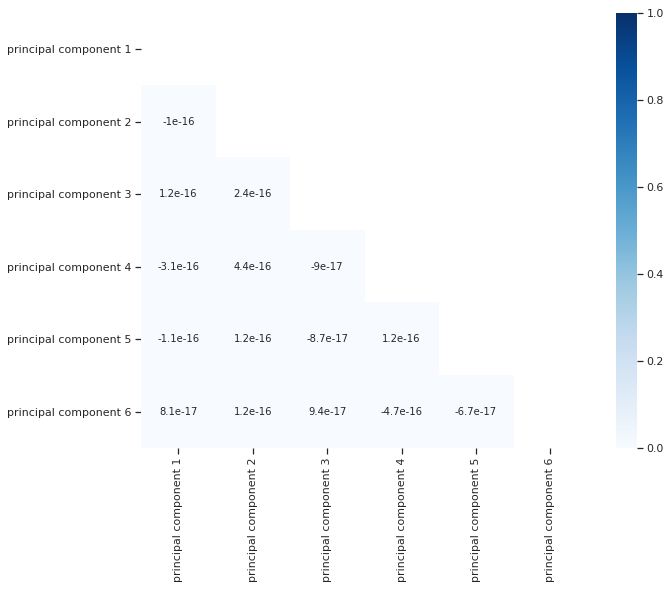

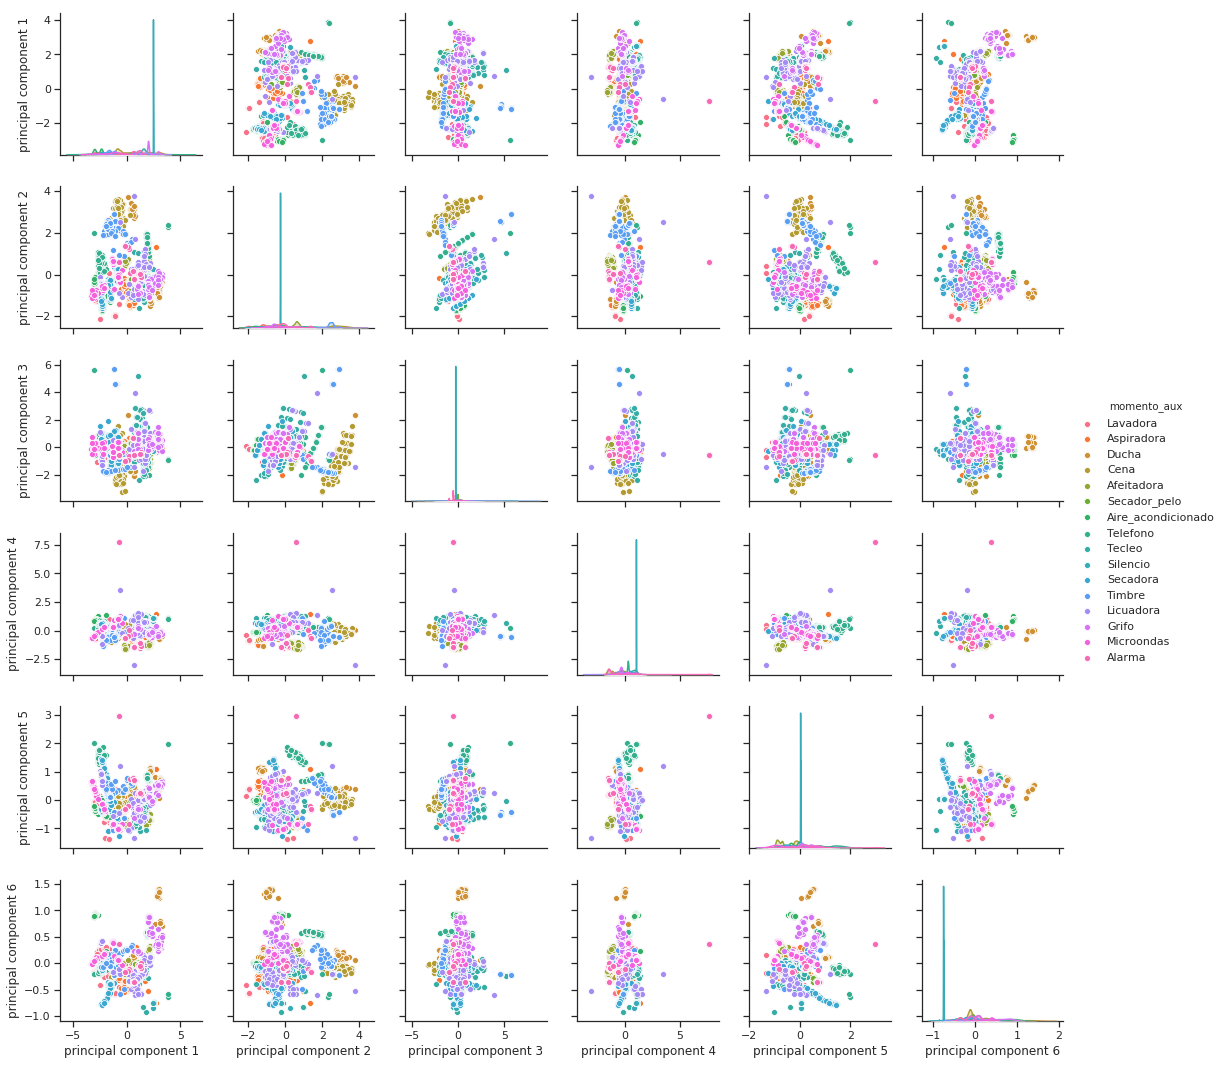

In [53]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

    sns.set(style="ticks")
    sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento_aux')

In [54]:
y = pd.get_dummies(data=finalDf.momento_aux)
X = data.loc[:, finalDf.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [55]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.97986577 0.90540541 0.9527027  0.96621622 1.         0.93243243
 0.98648649 0.39864865 0.95945946 0.9527027  0.98648649 0.94594595
 0.96621622 0.93243243 0.84459459 0.92567568 0.97297297 1.
 0.96621622 0.94594595]
Accuracy: 0.93 (+/- 0.25)


In [56]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9612141652613828

In [57]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.01
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.00
Licuadora             0.01
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.01
dtype: float64 degrees.


In [58]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [59]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [60]:
indices = np.argsort(importances)[::-1]

In [61]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.227067)
2. feature 4 (0.223243)
3. feature 1 (0.194454)
4. feature 0 (0.169890)
5. feature 3 (0.147709)
6. feature 5 (0.037636)


,importance
scom,0.227067
sbwm,0.223243
scem,0.194454
mfcc,0.169890
srom,0.147709
tempo,0.037636


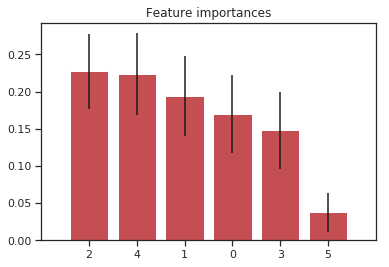

In [62]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [63]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9612141652613828

In [64]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9628968707196454

In [65]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.673077,1.000000,0.804598
Ducha,1.000000,0.969697,0.984615
Lavadora,1.000000,0.942857,0.970588
Aspiradora,0.911765,0.885714,0.898551
Afeitadora,1.000000,0.965517,0.982456
Secador_pelo,0.976744,0.976744,0.976744
Aire_acondicionado,1.000000,1.000000,1.000000
Telefono,0.983871,1.000000,0.991870
Tecleo,1.000000,0.860000,0.924731


Confusion matrix, without normalization
[[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 28  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 42  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 61  0  0  0  0  0  0  0  0]
 [ 5  0  0  2  0  0  0  0 43  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 33  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0 33  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 26  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 22  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 39]]


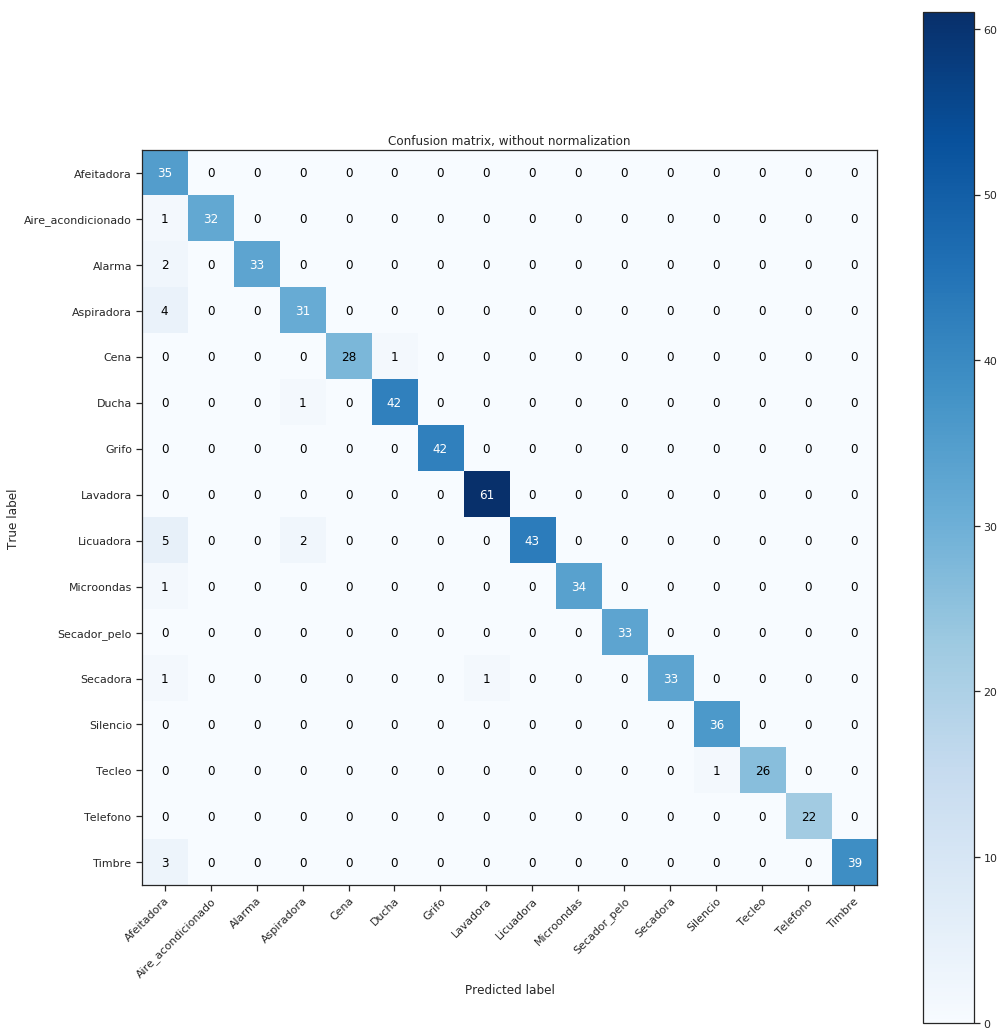

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [67]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [69]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [70]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [71]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [72]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [73]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [74]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

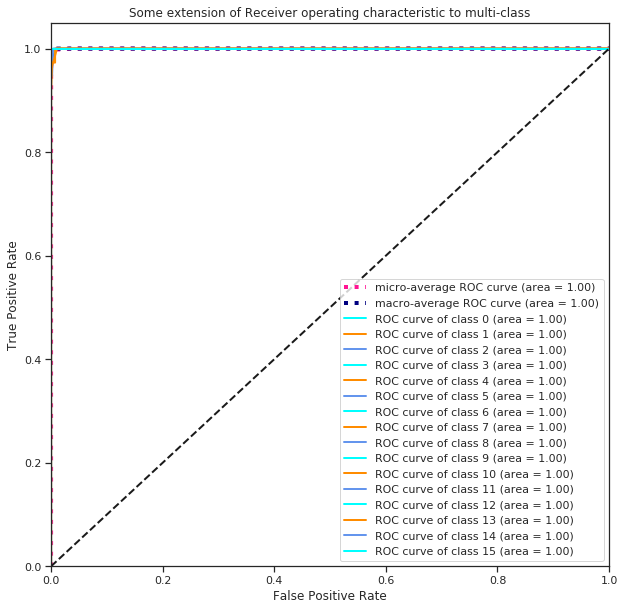

In [75]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 4

In [76]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [77]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')

In [ ]:
features = ['mfcc', 'scem', 'scom', 'srom', 'sbwm', 'tempo', 'rmse']

x = data.loc[:, features].values
y = data.loc[:,['momento_aux']].values

x = StandardScaler().fit_transform(x)

In [78]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4
0,-2.908475,-1.183207,0.004665,-0.692620
1,0.597411,-1.375698,0.282320,-0.717515
2,0.580970,3.266432,-0.161297,0.105091
3,-0.744115,-1.413075,0.030856,-0.458438
4,-2.020234,-1.225178,-0.258659,0.596813


In [79]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento_aux']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,momento_aux
0,-2.908475,-1.183207,0.004665,-0.692620,Lavadora
1,0.597411,-1.375698,0.282320,-0.717515,Aspiradora
2,0.580970,3.266432,-0.161297,0.105091,Ducha
3,-0.744115,-1.413075,0.030856,-0.458438,Lavadora
4,-2.020234,-1.225178,-0.258659,0.596813,Lavadora


In [80]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.48546933 0.20640729 0.13593341 0.09685188] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 92.47%.
La variación perdida con respecto al modelo original ha sido del 7.53%.


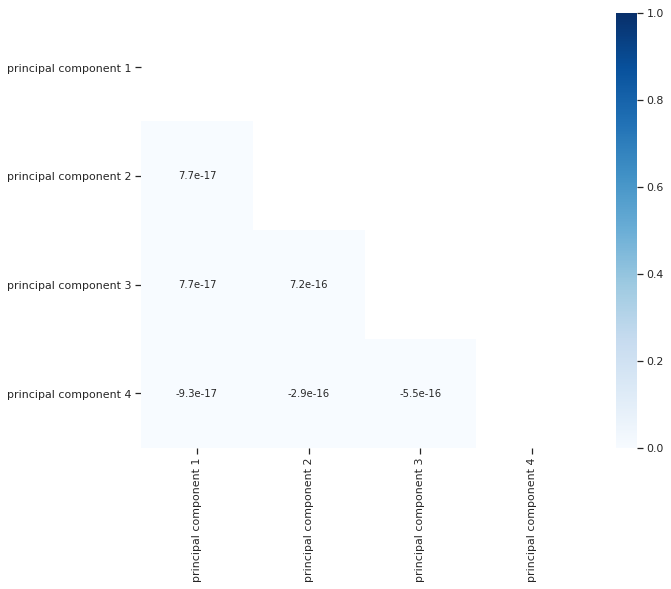

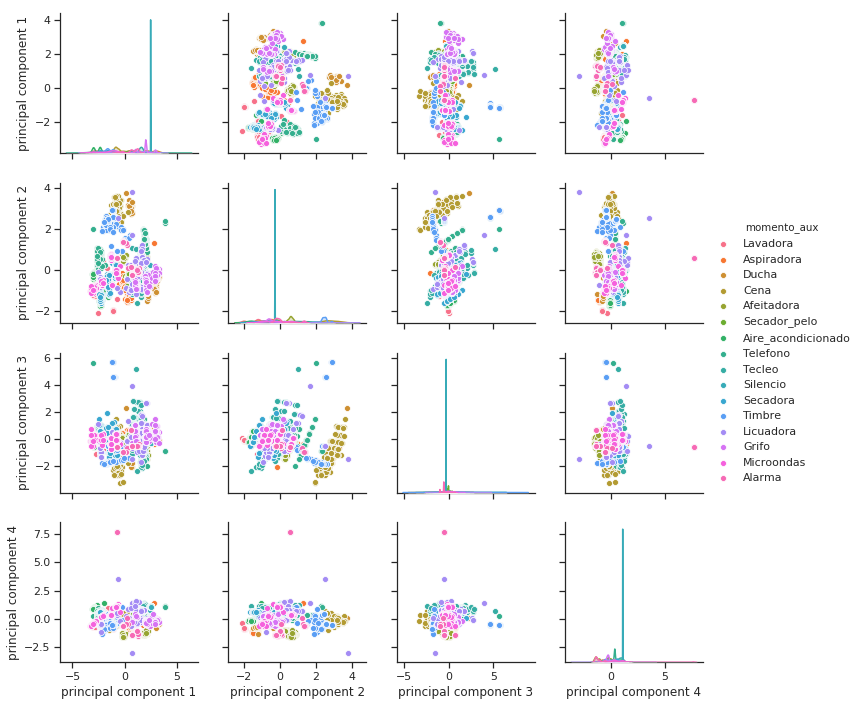

In [81]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

    sns.set(style="ticks")
    sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento_aux')

In [82]:
y = pd.get_dummies(data=finalDf.momento_aux)
X = data.loc[:, finalDf.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [83]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.97986577 0.91891892 0.94594595 0.95945946 0.99324324 0.90540541
 0.98648649 0.22297297 0.95945946 0.89864865 1.         0.93243243
 0.95945946 0.92567568 0.83108108 0.91216216 0.96621622 1.
 0.93918919 0.9527027 ]
Accuracy: 0.91 (+/- 0.32)


In [84]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9527824620573356

In [85]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.01
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.01
Licuadora             0.01
Microondas            0.01
Secador_pelo          0.00
Secadora              0.01
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.01
dtype: float64 degrees.


In [86]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [87]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [88]:
indices = np.argsort(importances)[::-1]

In [89]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.288723)
2. feature 0 (0.262178)
3. feature 1 (0.241140)
4. feature 3 (0.207959)


,importance
scom,0.288723
mfcc,0.262178
scem,0.241140
srom,0.207959


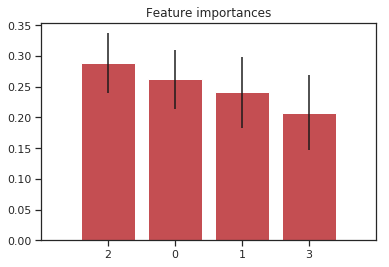

In [90]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [91]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9527824620573356

In [92]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9517751421918915

In [93]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.592593,1.000000,0.744186
Ducha,1.000000,0.975610,0.987654
Lavadora,1.000000,0.978261,0.989011
Aspiradora,0.941176,0.941176,0.941176
Afeitadora,1.000000,0.920000,0.958333
Secador_pelo,1.000000,0.975610,0.987654
Aire_acondicionado,1.000000,0.947368,0.972973
Telefono,0.933333,0.976744,0.954545
Tecleo,1.000000,0.871795,0.931507


Confusion matrix, without normalization
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 40  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 42  0  0  0  0  0  0  0  0]
 [ 3  0  0  1  0  0  0  0 34  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  1  0 33  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  1  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 48  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0 37  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 24  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38]]


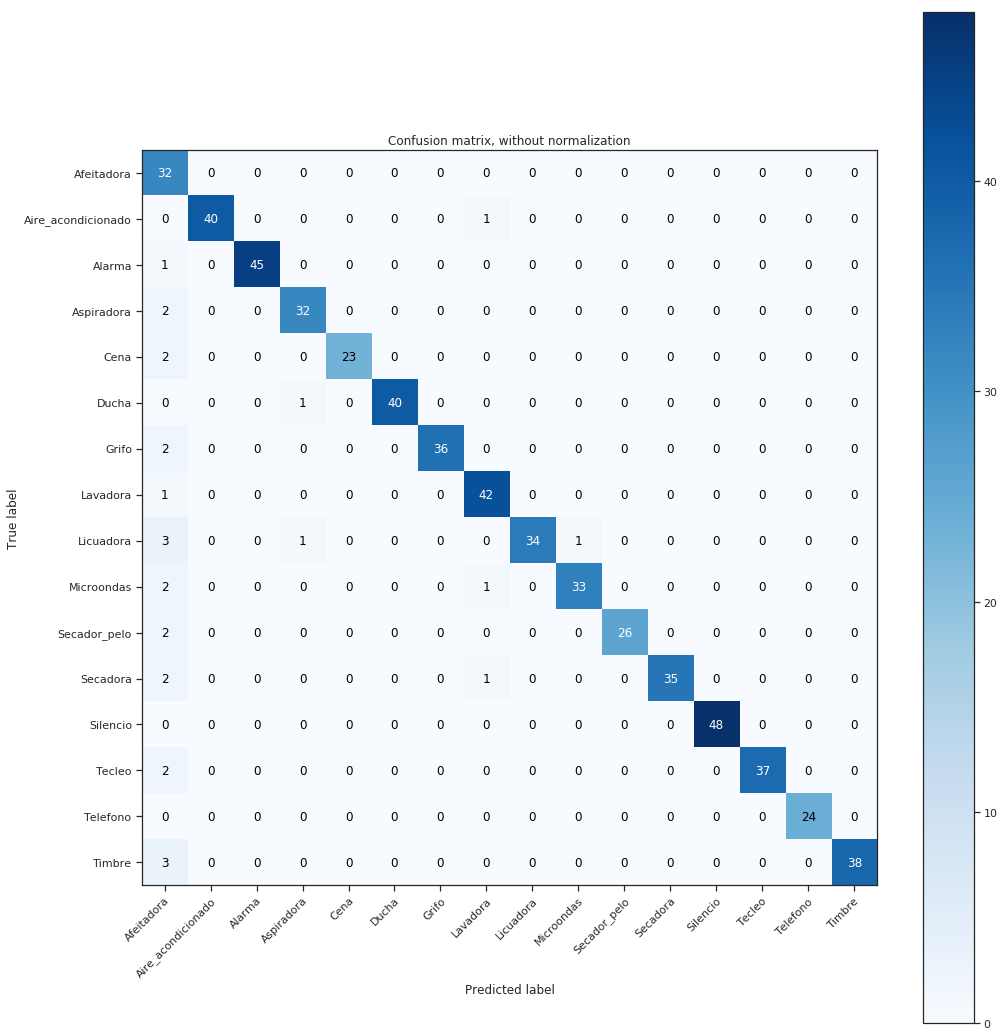

In [94]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [95]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [97]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [98]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [99]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [100]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [101]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [102]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

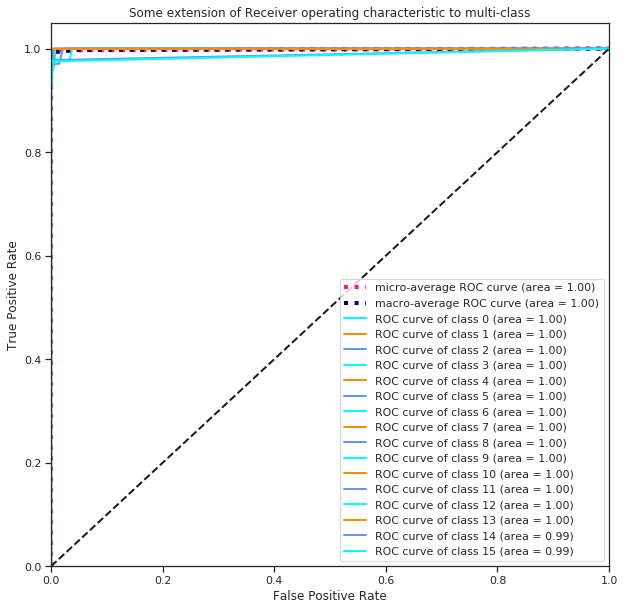

In [103]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Conclusiones

Como se ha podido observar en los diferentes resultados, tras aplicar los diferentes PCA no ha habido una mejora sustancial en la calidad de la regresión, obteniendo prácticamente los mismos scores y predicciones que sin PCA.

Además habría que tener en cuenta la aleatoriedad a la hora de seleccionar el train set y test set. Es por ello, que voy a dejar el modelo final tal y como estaba y no le voy a aplicar ningín PCA.